In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import torch.nn as nn
import typing as tp
from torch.nn import functional as F

import swyft
from swyft.lightning.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, SampleStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples,
    RatioSampleStore
)

- p(x, z) log(sigmoid(logr(x, z))) + p(x)p(z) log(sigmoid(-logr(x, z)))
- p(x)p(z|x) log p(z|x)/p(z)

## Problem-specific analysis components



100%|██████████| 1/1 [00:00<00:00, 404.62it/s]


100%|██████████| 1/1 [00:00<00:00, 2535.85it/s]


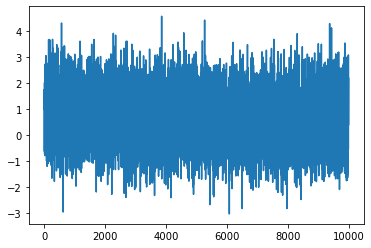

In [ ]:
class Model(SwyftModel):
    def fast(self, S):
        d = S['mu'] + torch.randn_like(S['mu'])*1
        return SampleStore(data = d)
        
    def slow(self, S):
        a, b, c = S['z']
        x = np.linspace(-1, 1, 10000)
        mu = a+b*x + c*x**2
        return SampleStore(mu=mu.float())

    def prior(self, N, bounds = None):
        low = -np.ones(3)
        high = np.ones(3)
        if bounds is not None:
            low, high = bounds['z'].low, bounds['z'].high
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return SampleStore(z = torch.tensor(draw).float())
    
m = Model()
plt.plot(m.sample(1)[0]['data'])

## Definition of target image

In [4]:
class InferenceNet(SwyftModule):
    def __init__(self):
        super().__init__()
        #self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv1d(1, 10, 3),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(10, 20, 3),
            torch.nn.MaxPool1d(2),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.ptrans = swyft.networks.ParameterTransform(
            3, [(0,), (1,), (2,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 16
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.1,
            num_blocks=3,
        )
        
    def forward(self, x, z):
        # Digesting x
        data = x['data']
        #x = self.online_z_score(x)['img']
        x = self.CNN(data.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = self.ptrans(z['z'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        w = RatioSamples(z.squeeze(-1), ratios)
        return dict(z=w)

In [347]:
class InferenceNet2(SwyftModule):
    def __init__(self):
        super().__init__()
        #self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.l = nn.LazyLinear(20)
        self.ptrans = swyft.networks.ParameterTransform(
            3, [(0,), (1,), (2,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 20
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.5,
            num_blocks=2,
        )
        
    def forward(self, x, z):
        # Digesting x
        data = x['data']
        #x = self.online_z_score(x)['img']
        #data = torch.cat([torch.fft.rfft(data).real, torch.fft.rfft(data).imag], dim =-1)
        data = trans(data)
        x = self.l(data)
        
        # Digesting z
        z = self.ptrans(z['z'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        #self.log("metric123", ratios.sum(), prog_bar = True)
        w = RatioSamples(z.squeeze(-1), ratios)
        return dict(z=w)

## Workflow

In [348]:
def trans(d):
    C = 5
    return torch.cat([torch.fft.rfft(d).real[..., :C], torch.fft.rfft(d).imag[..., :C]], dim =-1)/1000



100%|██████████| 1/1 [00:00<00:00, 410.24it/s]


100%|██████████| 1/1 [00:00<00:00, 2634.61it/s]


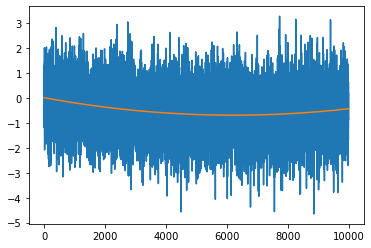

In [349]:
m = Model()
s0 = m.sample(1)[0]
plt.plot(s0['data'])
plt.plot(s0['mu'])
#plt.plot(s0['data'])
#d = trans(d)
#plt.plot(d)

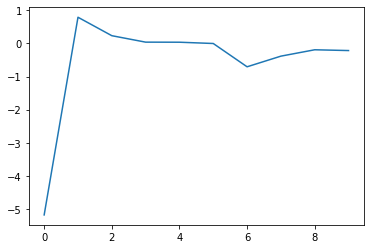

In [350]:
plt.plot(trans(s0['data']))

In [378]:
b = None
m = Model()
for i in range(1):
    r = InferenceNet2()
    #s = m.sample(10000, bounds = b)
    d = SwyftDataModule(s, model = None, batch_size = 128, train_multiply = 3)
    t = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 40)
    t.fit(r, d)
    p = t.infer(r, d, condition_x = s0)   # Weighted posterior samples
    b = get_1d_rect_bounds(p, th = 1e-7)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | l          | LazyLinear         | 0     
1 | ptrans     | ParameterTransform | 0     
2 | classifier | MarginalClassifier | 813 K 
--------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.253     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 63it [00:00, ?it/s]

In [379]:
t.test(r, d)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.1665207147598267}
--------------------------------------------------------------------------------


[{'test_loss': 1.1665207147598267}]

In [377]:
t.test(r, d)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.269152045249939}
--------------------------------------------------------------------------------


[{'test_loss': 1.269152045249939}]

In [375]:
t.test(r, d)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.1194003820419312}
--------------------------------------------------------------------------------


[{'test_loss': 1.1194003820419312}]

In [366]:
z = p['z'].sample(10000, replacement = True)
len(z)

10000

In [263]:
d.dataset_train[0]

({'data': tensor([-0.1917,  1.8959,  0.7405,  ..., -0.2712, -1.6125,  0.2031]),
  'z': tensor([-0.3681, -0.7495,  0.9068]),
  'mu': tensor([ 1.2883,  1.2877,  1.2872,  ..., -0.2112, -0.2110, -0.2108])},
 {'data': tensor([-0.1917,  1.8959,  0.7405,  ..., -0.2712, -1.6125,  0.2031]),
  'z': tensor([-0.3681, -0.7495,  0.9068]),
  'mu': tensor([ 1.2883,  1.2877,  1.2872,  ..., -0.2112, -0.2110, -0.2108])})

(-1.0, 1.0)

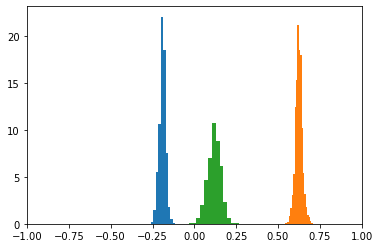

In [83]:
plt.hist(z[:,0].numpy(), bins = 20, density=True);
plt.hist(z[:,1].numpy(), bins = 20, density = True);
plt.hist(z[:,2].numpy(), bins = 20, density = True);
plt.xlim(-1, 1)